# Table of Contents
 
 <p>
    <div class="lev2 toc-item"><a href="#ALF-class">Advanced Lane Finding class</a></div>
    <div class="lev2 toc-item"><a href="#Line-class">Line class</a></div>
 	<div class="lev2 toc-item"><a href="#Camera-Calibration">1 Camera Calibration</a></div>
 	<div class="lev2 toc-item"><a href="#Distortion-correction">2 Distortion Correction</a></div>
 	<div class="lev2 toc-item"><a href="#grad-xform-test">3 Color Transform &amp; Gradient</a></div>
 	<div class="lev2 toc-item"><a href="#persp-xform-test">4 Perspective Transform</a></div>
 	<div class="lev1 toc-item"><a href="#lane-id-poly-test">5 Identify lane lines &amp; fit to a polynomial</a></div>
 	<div class="lev1 toc-item"><a href="#prev-frame-fit-test">5.1 Previous frame fit</a></div>
 	<div class="lev1 toc-item"><a href="#rad-curv-test">6 Radius of curvature</a></div>
	<div class="lev1 toc-item"><a href="#lane-area-id-test">7 Lane area identification test</a></div>
	<div class="lev1 toc-item"><a href="#video-proc">8 Video processing</a></div>

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

#### Advanced Lane Finding class
<a id='ALF-class'></a>

In [2]:
# This class has methods for -
# 1. Calculate calibration coefficients
# 2. Correct for distortion
# 3. Calculate absolute, magnitude & direction sobel
# 4. Color gradient threshold computation for RGB and HLS
# 5. Perspective warp processing based on the src & destination points passed into the ctor
# 6. Sliding windows for both lanes and fitting them to a 2nd order polynomial
# 7. Fitting a new frame based on a previous one
# 8. Calculate radius of curvature for lanes given the lane fits
# 9. Project polyfill back to actual road and fill the space between polyfits to indicate lanes
# 10. Process video, frame by frame using all the above methods

class AdvancedLaneFinding():
    
    #ctor takes in src & dest points for warp
    def __init__(self, src, dest):
        self.src = src
        self.dest = dest
        self.M = cv2.getPerspectiveTransform(self.src, self.dest)
        self.inverse_M = cv2.getPerspectiveTransform(self.dest, self.src)
    
    # Computes the camera calibration for all the images in the input folder path and returns the matrix and distortion coefficients
    def calc_calibration_coeffs(self, image_url):
        images = glob.glob(image_url)

        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
        corner = (9, 6)

        for image in images:
            img = cv2.imread(image)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, corner, None)

            if ret:            
                objpoints.append(objp)
                imgpoints.append(corners)

        img_size = (img.shape[1], img.shape[0])
        ret, mtx, dst, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        self.mtx = mtx
        self.dst = dst

    #Undistort input image & returns the undistorted image     
    def undistort_img(self, img):
        dst = cv2.undistort(img, self.mtx, self.dst, None, self.mtx)
        return dst
    
    # Absolute sobel for x & y axes
    def abs_sobel(self, img, sobel_kernel=3, abs_thresh=(0,255), orient='x'):
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        orient_x, orient_y = 1, 0
        if orient == 'y':
            orient_x, orient_y = 0, 1
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, orient_x, orient_y,sobel_kernel)
        abs_sobel = np.abs(sobel)
        scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
        return grad_binary
    
    # Magnitude gradient
    def mag_sobel(self, image, sobel_kernel=3, mag_thresh=(0,255)):
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1,0, sobel_kernel)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0,1, sobel_kernel)
        abs_sobelx = np.abs(sobelx)
        abs_sobely = np.abs(sobely)
        sobel_mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
        scaled_sobel = np.uint8(255*sobel_mag / np.max(sobel_mag))
        sbinary = np.zeros_like(scaled_sobel)
        sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        return sbinary
    
    # Direction of the gradient
    def dir_sobel(self, image, sobel_kernel=3, dir_thresh=(0,255)):
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1,0, sobel_kernel)
        sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0,1, sobel_kernel)
        abs_sobelx = np.abs(sobelx)
        abs_sobely = np.abs(sobely)
        grad_dir = np.arctan2(abs_sobely, abs_sobelx)
        dir_binary = np.zeros_like(grad_dir)
        dir_binary[(grad_dir >= dir_thresh[0]) & (grad_dir <= dir_thresh[1])] = 1
        return dir_binary
    
    # Combined sobel, magnitude and direction gradient
    def combined_grad(self, image, kernel=3, abs_thresh=(30,100), mag_thresh = (10,100), dir_thresh = (0,0.5)):
        gradx = self.abs_sobel(image, kernel, abs_thresh, orient='x')
        grady = self.abs_sobel(image, kernel, abs_thresh, orient='y')
        mag_binary = self.mag_sobel(image, kernel, mag_thresh)
        dir_binary = self.dir_sobel(image, kernel, dir_thresh)
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        return combined
    
    #HLS threshold for S channel
    def hls_sthresh(self, img, thresh=(80, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        hls_s = hls[:,:,2]
        hls_s = hls_s*(255/np.max(hls_s))
        binary_output = np.zeros_like(hls_s)
        binary_output[(hls_s > thresh[0]) & (hls_s <= thresh[1])] = 1
        return binary_output
    
    #RGB threshold for R channel
    def rgb_rthresh(self, img, thresh=(230, 255)):
        rgb_r = img[:,:,0]
        rgb_r = rgb_r*(255/np.max(rgb_r))
        binary_output = np.zeros_like(rgb_r)
        binary_output[(rgb_r > thresh[0]) & (rgb_r <= thresh[1])] = 1
        return binary_output
    
    #Perspective x'form
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    
    #Inverse perspective
    def inverse_transform(self, undist):
        return self.inverse_M
    
    # Undistort, Apply gradient & color threshold and finally warp the input image
    def binary_img_pipeline(self, img):
        undist_img = self.undistort_img(img)
        warped_img = self.transform(undist_img)
        M_inv = self.inverse_transform(undist_img)
        grad_img = self.combined_grad(warped_img)
        hls_s_img = self.hls_sthresh(warped_img)
        rgb_r_img = self.rgb_rthresh(warped_img)
        binary_warped = np.zeros_like(hls_s_img)
        binary_warped[((hls_s_img == 1) & (grad_img == 1)) | (rgb_r_img == 1)] = 1
        return binary_warped, M_inv
    
    
    # Fits a polynomial to each lane in the input image
    def sliding_window_lane_fit_polynomial(self, binary_warped):
    
        # Histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

        # Peak of the left & right halves to be used as starting point for respective lanes
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9

        window_height = np.int(binary_warped.shape[0]/nwindows)
        # x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        window_data = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            window_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        return left_fit, right_fit, left_lane_inds, right_lane_inds, window_data, histogram
    
    # Fits lane for the input image given left & right lane fits for the previous frame
    def lane_fit_from_prev_frame(self, binary_warped, left_fit, right_fit):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit, left_lane_inds, right_lane_inds
    
    # Caclulates radius of curvature given the image, lane fits & indices
    def calc_radius_curvature(self, bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
        
        ym_per_pix = 30.0/720 
        xm_per_pix = 3.7/700 
        left_curverad, right_curverad, center_dist = (0, 0, 0)
        
        h = bin_img.shape[0]
        ploty = np.linspace(0, h-1, h)
        y_eval = np.max(ploty)
        
        nonzero = bin_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        leftx = nonzerox[l_lane_inds]
        lefty = nonzeroy[l_lane_inds] 
        rightx = nonzerox[r_lane_inds]
        righty = nonzeroy[r_lane_inds]

        if len(leftx) != 0 and len(rightx) != 0:
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            radius = int((left_curverad+right_curverad)/2)

        
        if r_fit is not None and l_fit is not None:
            car_position = bin_img.shape[1]/2
            l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
            r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
            lane_center_position = (r_fit_x_int + l_fit_x_int) /2
            center_dist = abs(car_position - lane_center_position) * xm_per_pix

        return int((left_curverad + right_curverad)/2), center_dist, lane_center_position
    
    # Identifies area between 2 lanes and projects onto original image
    def lane_area_identify(self, original_img, binary_img, l_fit, r_fit, Minv):
        new_img = np.copy(original_img)
        if l_fit is None or r_fit is None:
            return original_img
        
        warp_zero = np.zeros_like(binary_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        h,w = binary_img.shape
        ploty = np.linspace(0, h-1, num=h)
        left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
        right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
        
        newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
        result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
        return result
    
    # Projects stats for curvature & distance to the original image
    def project_to_road(self, original_img, curv_rad, center_dist, position):
        new_img = np.copy(original_img)
        h = new_img.shape[0]
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Radius of curvature is {}m'.format(curv_rad)
        cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        direction = ''
        if center_dist > 0:
            direction = 'right'
        elif center_dist < 0:
            direction = 'left'
        abs_center_dist = abs(center_dist)
        text = 'Vehicle is {:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
        cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        return new_img
    
    # Fits line with the found fits
    def add_line_fit(self, line, fit, inds):
        if fit is not None:
            if line.best_fit is not None:
                line.diffs = abs(fit-line.best_fit)
            if self.check_line_fit(line):   # we are back to fitting the sliding window with a polynomial             
                line.detected = False
            else:
                line.detected = True
                line.px_count = np.count_nonzero(inds)
                line.current_fit.append(fit)
                if len(line.current_fit) > 5:                    
                    line.current_fit = line.current_fit[len(line.current_fit)-5:]
                line.best_fit = np.average(line.current_fit, axis=0)
        else:
            line.detected = False
            if len(line.current_fit) > 0:
                line.current_fit = line.current_fit[:len(line.current_fit)-1]
                line.best_fit = np.average(line.current_fit, axis=0)

    # Check for false fit            
    def check_line_fit(self, line):
        return (line.diffs[0] > 0.001 or line.diffs[1] > 1.0 or line.diffs[2] > 100.) and len(line.current_fit) > 0
    
    # Set line object to be used in the stream
    def set_line(self):
         self.l_line = Line()
         self.r_line = Line()
        
    # Process each image frame in the video stream
    def process_image_frame(self, img):
        new_img = np.copy(img)
        img_bin, _ = self.binary_img_pipeline(new_img)
       
        if not self.l_line.detected or not self.r_line.detected:
            l_fit, r_fit, l_lane_inds, r_lane_inds, windows_data, histogram = self.sliding_window_lane_fit_polynomial(img_bin)
        else:
            l_fit, r_fit, l_lane_inds, r_lane_inds = self.lane_fit_from_prev_frame(img_bin, self.l_line.best_fit, self.r_line.best_fit)

        self.add_line_fit(self.l_line, l_fit, l_lane_inds)
        self.add_line_fit(self.r_line, r_fit, r_lane_inds)
        
        if self.l_line.best_fit is not None and self.r_line.best_fit is not None:
            img_out1 = self.lane_area_identify(new_img, img_bin, self.l_line.best_fit, self.r_line.best_fit, Minv)
            radius, d_center, position = self.calc_radius_curvature(img_bin, self.l_line.best_fit, self.r_line.best_fit, 
                                                                   l_lane_inds, r_lane_inds)
            img_out = self.project_to_road(img_out1, radius, d_center, position)
        else:
            img_out = new_img

        return img_out

#### Line class
<a id='Line-class'></a>

In [3]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None

#### 1. Camera calibration
<a id='Camera-Calibration'></a>

In [4]:
# Instantiate ALF class with src & dest points for warp, calculate and set calibration coefficients
src = np.array([[325, 650], [550, 475],[1000, 650],[750, 475]], dtype=np.float32)
dest = np.array([[300, 650], [400, 0], [850, 650],[1000, 0]], dtype=np.float32)
alf = AdvancedLaneFinding(src, dest)
alf.calc_calibration_coeffs('./camera_cal/calibration*.jpg')
mtx = alf.mtx
dst = alf.dst

#### Set test image

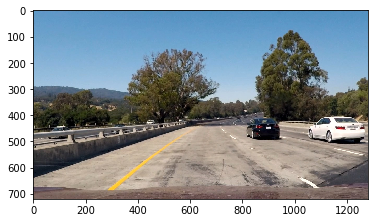

In [5]:
test_img = cv2.imread('./test_images/test1.jpg')
#convert RGB to BGR
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

#### 2. Distortion correction
<a id='Distortion-correction'></a>

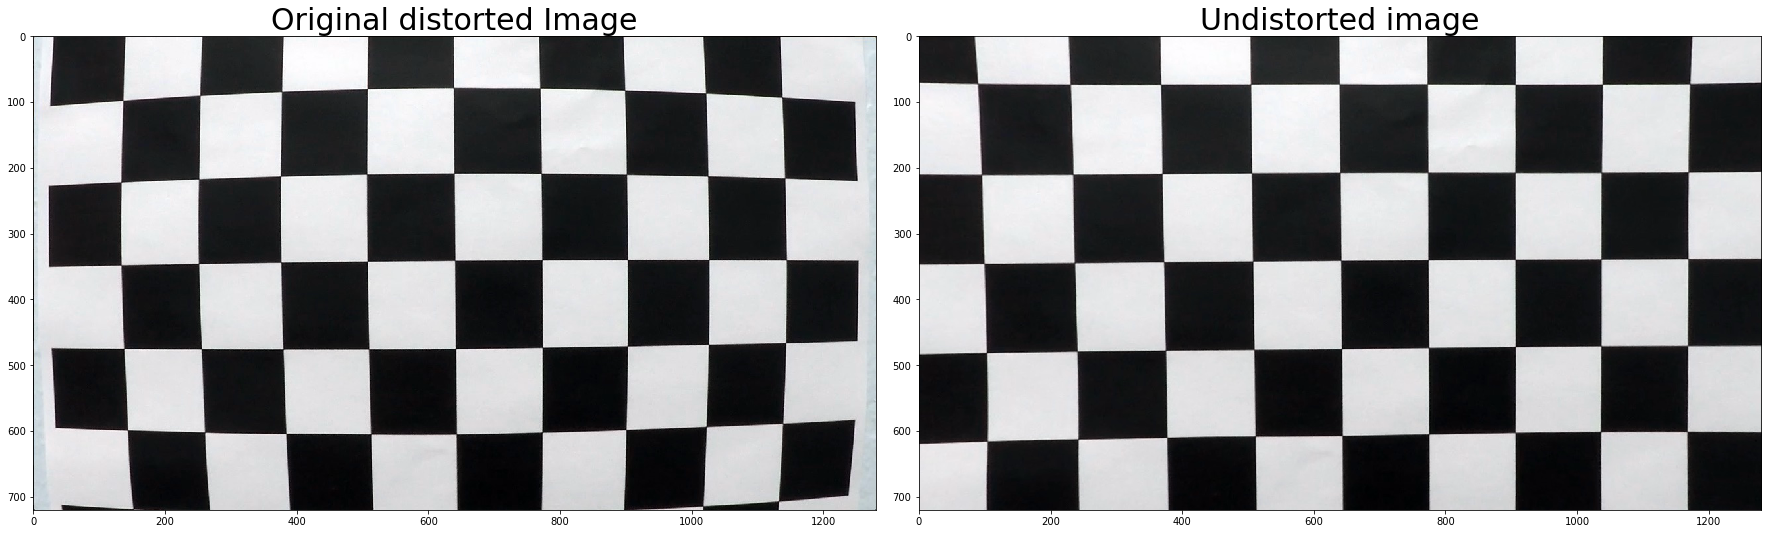

In [6]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = alf.undistort_img(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/undistorted_chess_image.png', undist)
ax1.imshow(img)
ax1.set_title('Original distorted Image', fontsize=30)

ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


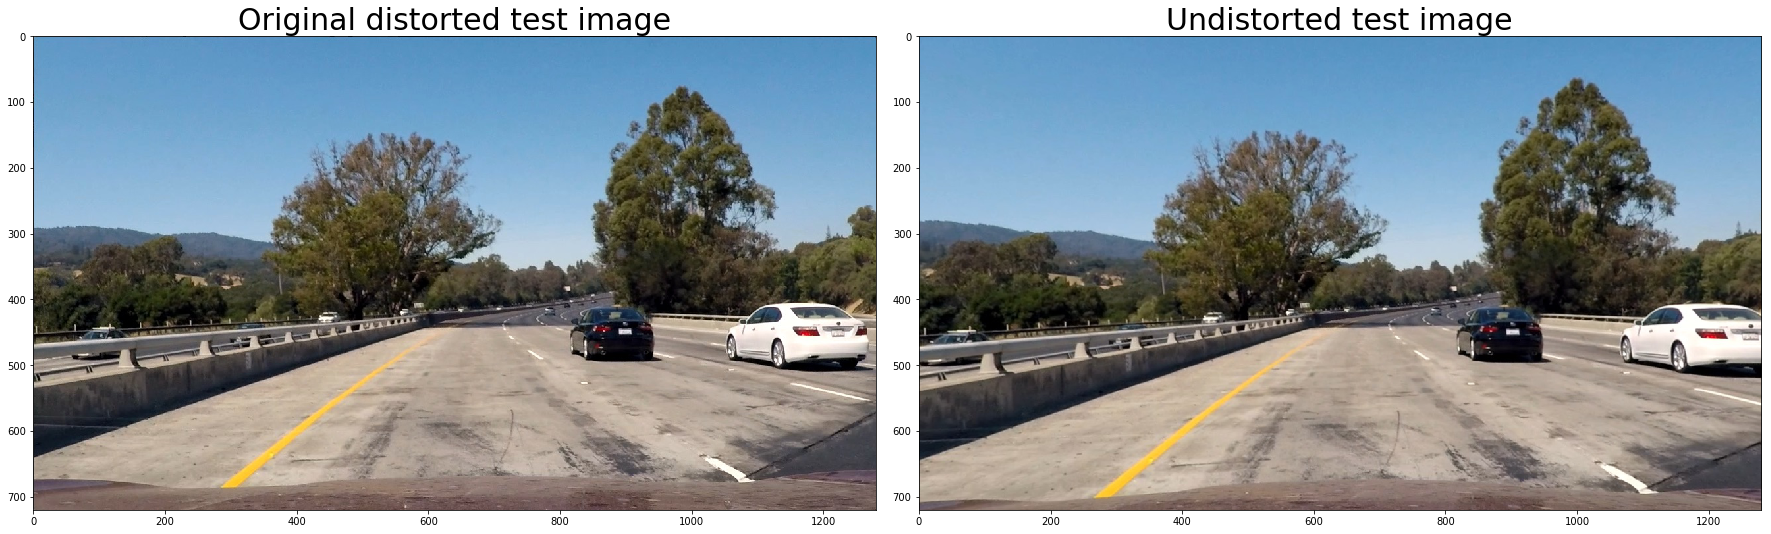

In [7]:
undist = alf.undistort_img(test_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/undistorted_test_image.png', undist)
ax1.imshow(test_img)
ax1.set_title('Original distorted test image', fontsize=30)

ax2.imshow(undist)
ax2.set_title('Undistorted test image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


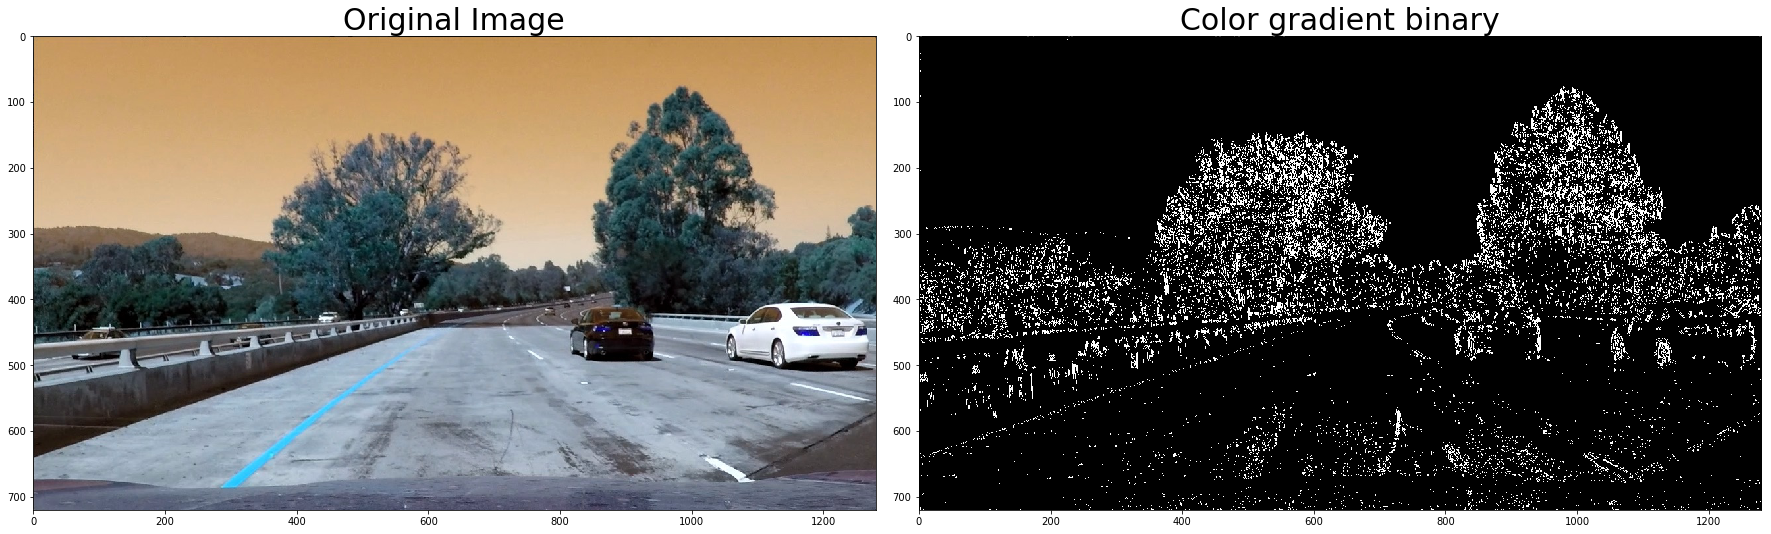

In [8]:
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
color_thresh = alf.combined_grad(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/grad_img.png', color_thresh, cmap='gray')
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(color_thresh, cmap='gray')
ax2.set_title('Color gradient binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3 Test of absolute, magnitude & directional gradient
<a id='grad-xform-test'></a>

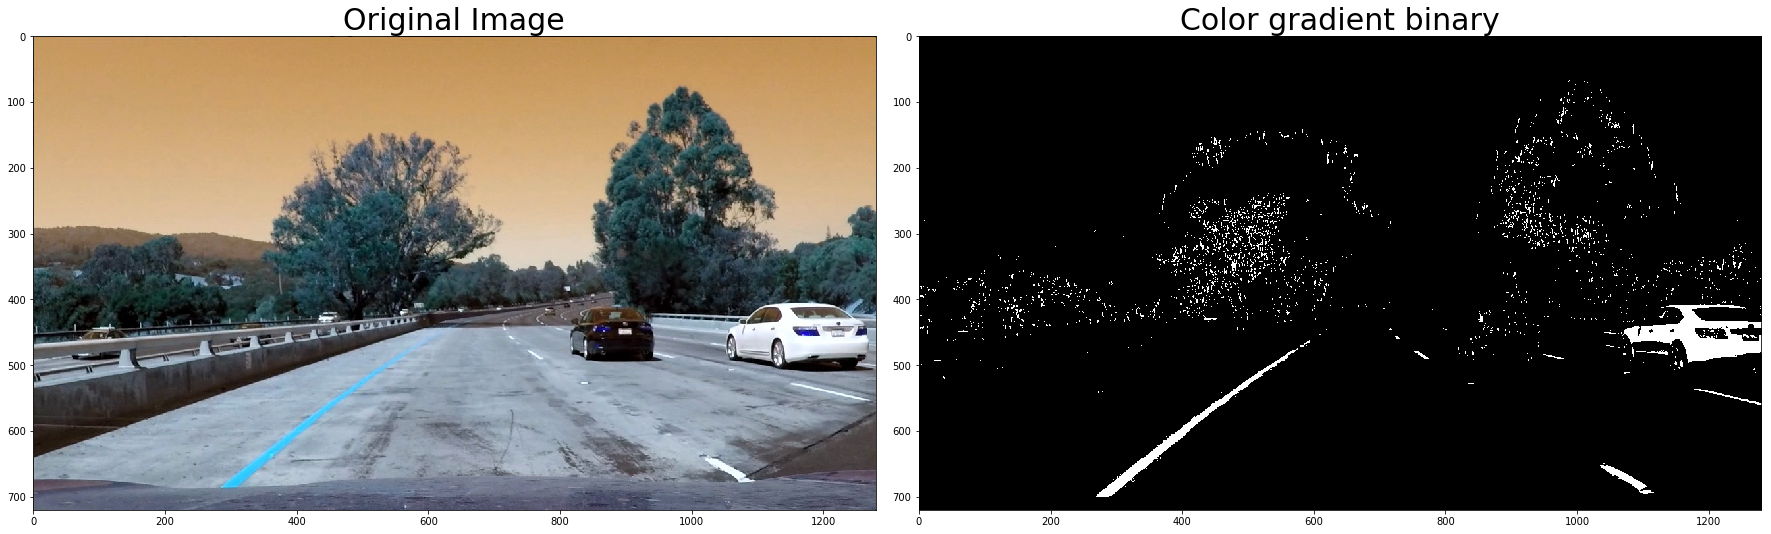

In [9]:
undist_img = alf.undistort_img(test_img)
grad_img = alf.combined_grad(undist_img)
hls_s_img = alf.hls_sthresh(undist_img)
rgb_r_img = alf.rgb_rthresh(undist_img)
binary_warped_test = np.zeros_like(hls_s_img)
binary_warped_test[((hls_s_img == 1) & (grad_img == 1)) | (rgb_r_img == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/color_grad_img.png', binary_warped_test, cmap='gray')
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(binary_warped_test, cmap='gray')
ax2.set_title('Color gradient binary', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 4 Perspective transform test
<a id='persp-xform-test'></a>

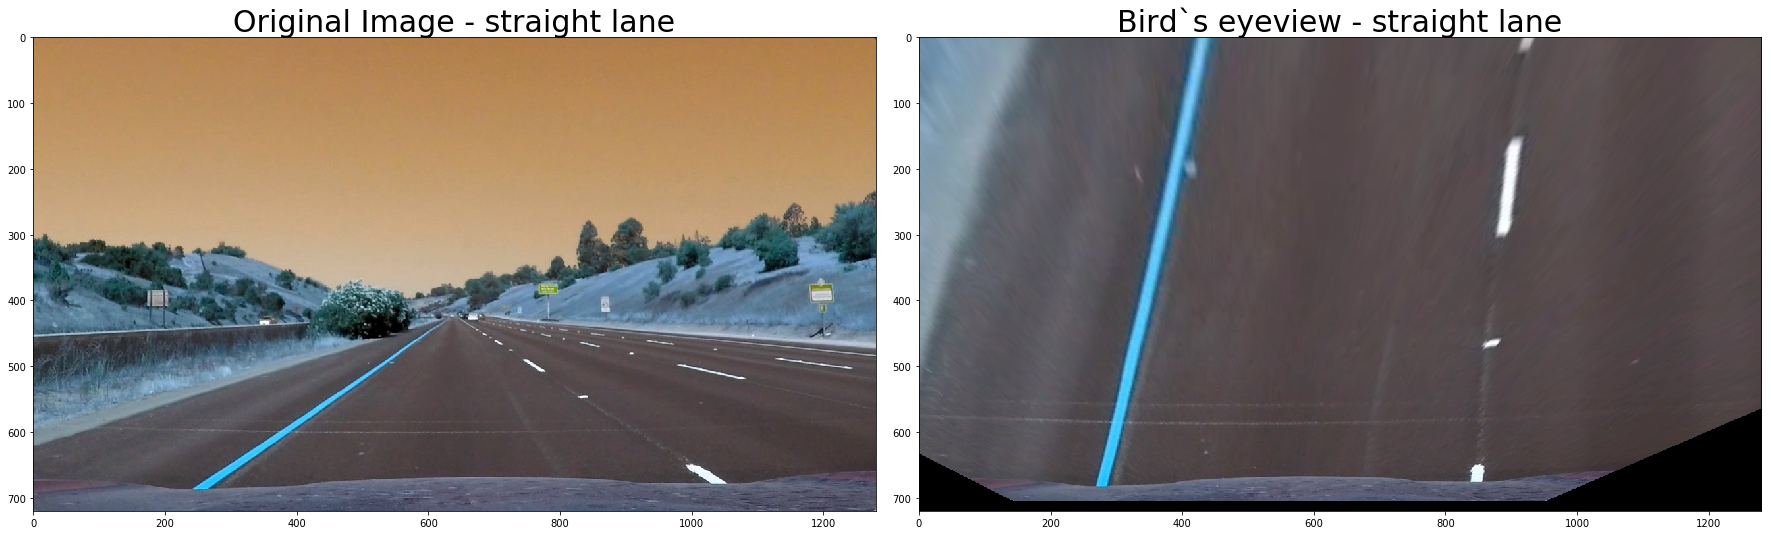

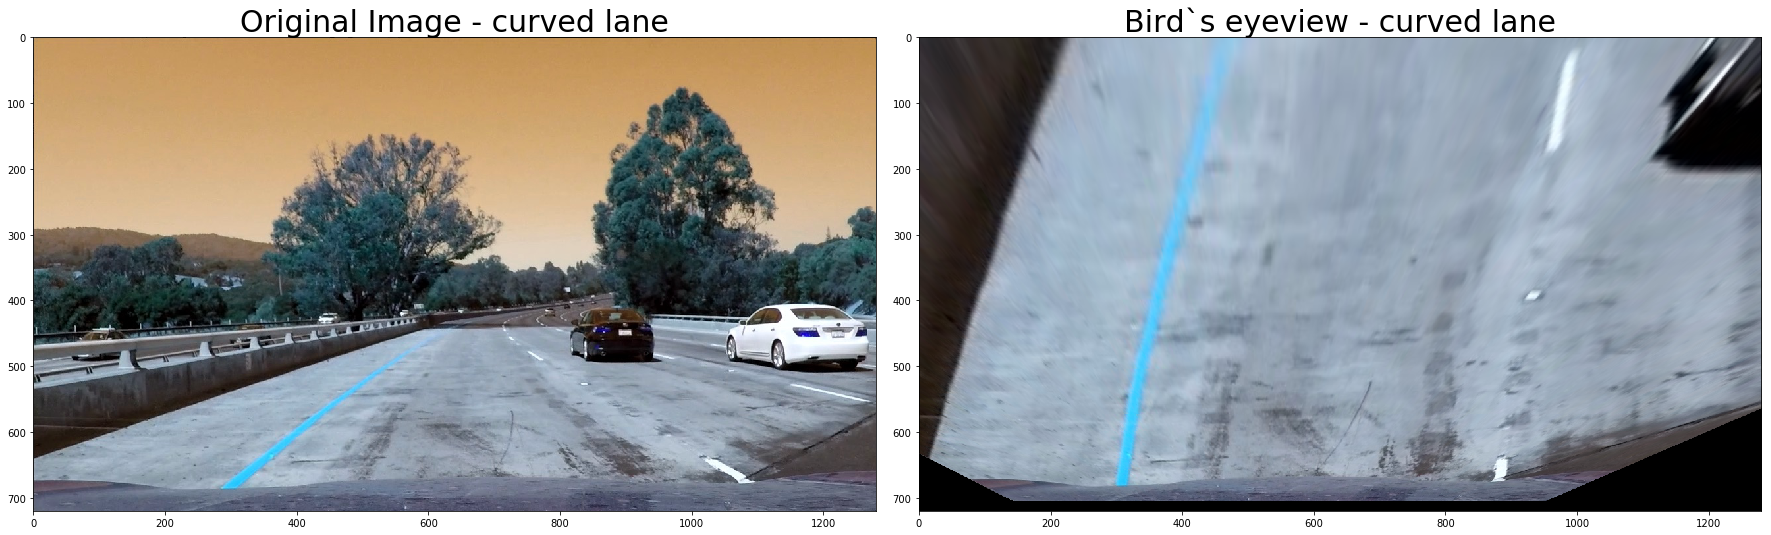

In [10]:
# Straight road warp

img_straight = cv2.imread('./test_images/straight_lines1.jpg')
img_size = (img_straight.shape[1], img_straight.shape[0])
top_down_view_straight = alf.transform(img_straight)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/persp_xform_straight.png', top_down_view_straight)
ax1.imshow(img_straight)
ax1.set_title('Original Image - straight lane', fontsize=30)

ax2.imshow(top_down_view_straight)
ax2.set_title('Bird`s eyeview - straight lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Curved road warp

img_curved = cv2.imread('./test_images/test1.jpg')
img_size = (img_curved.shape[1], img_curved.shape[0])
top_down_view_curved = alf.transform(img_curved)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave('./output_images/persp_xform_curved.png', top_down_view_curved)
ax1.imshow(img_curved)
ax1.set_title('Original Image - curved lane', fontsize=30)

ax2.imshow(top_down_view_curved)
ax2.set_title('Bird`s eyeview - curved lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Image pipeline test

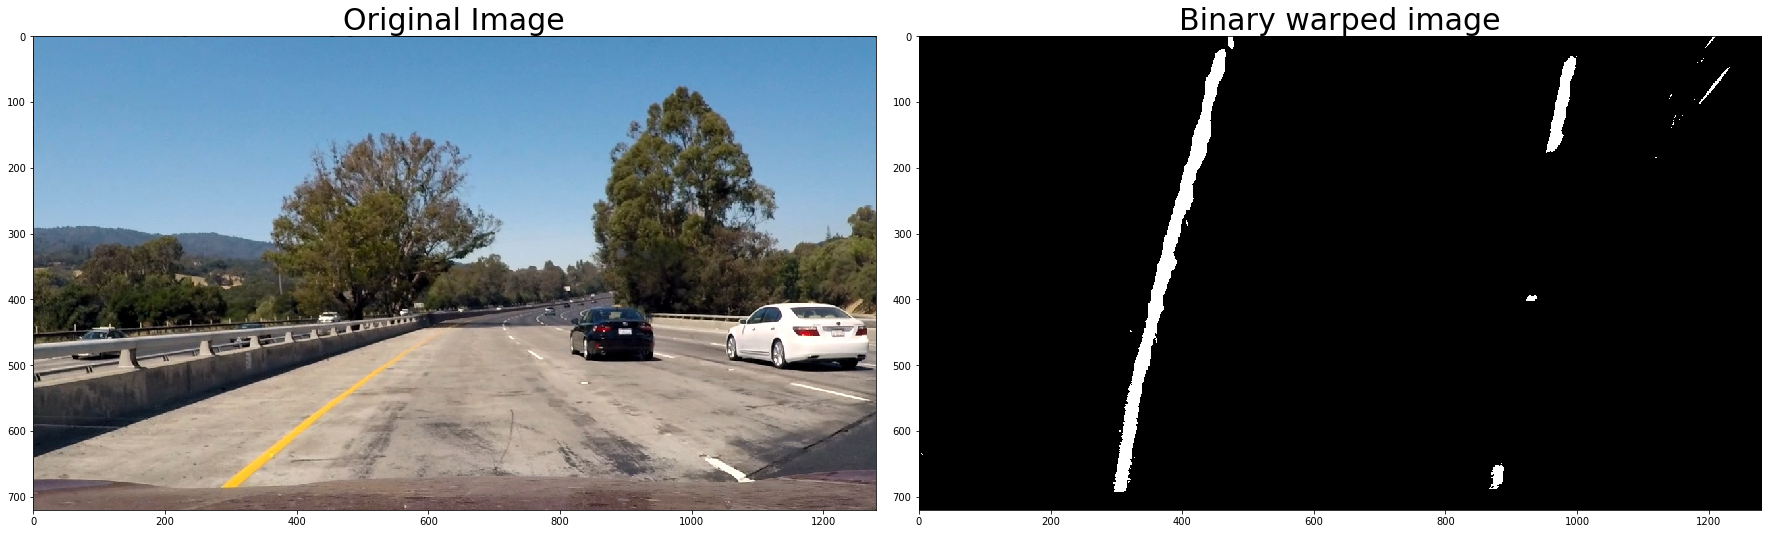

In [11]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_warped, _ = alf.binary_img_pipeline(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
plt.imsave('./output_images/pipeline_img.png', binary_warped, cmap='gray')
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary warped image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 5. Identify lane lines & fit to a polynomial
<a id='lane-id-poly-test'></a>

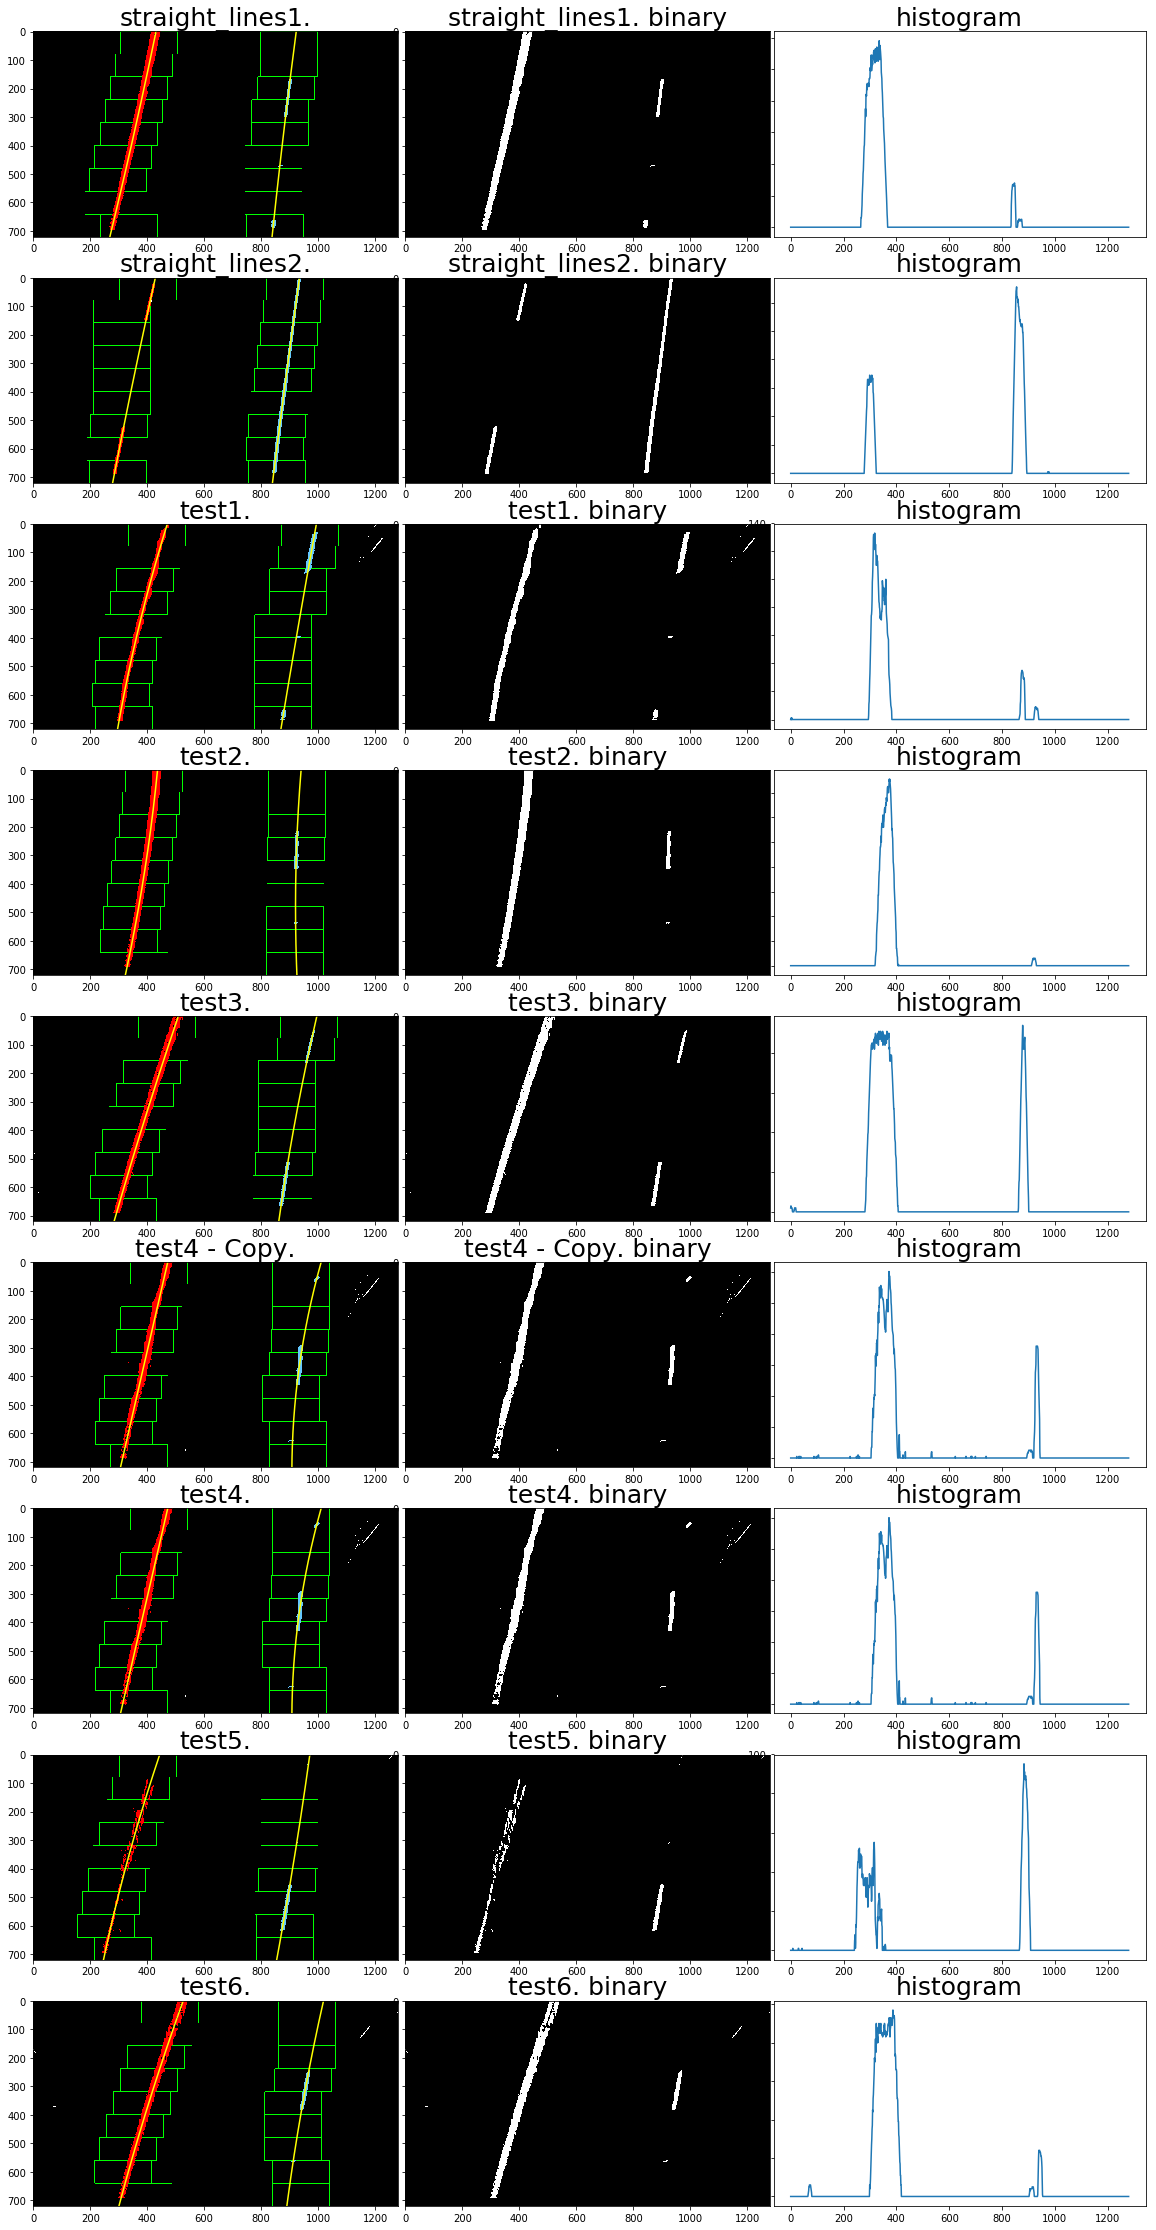

In [12]:
def sliding_window_lane_fit_polynomial_test(image):
    test_img = image
    
    if isinstance(image, str):
        test_img = cv2.imread(image)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    
    testimg_binary, _ = alf.binary_img_pipeline(test_img)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary)

    # Generate x and y values for plotting
    ploty = np.linspace(0, testimg_binary.shape[0]-1, testimg_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((testimg_binary, testimg_binary, testimg_binary))*255)

    for window in windows_data:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(window[2],window[0]),(window[3],window[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(window[4],window[0]),(window[5],window[1]),(0,255,0), 2) 

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = testimg_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    return out_img, left_fitx, right_fitx, ploty, testimg_binary, histogram

def sliding_window_lane_fit_polynomial_img_output(img):
    out_img, _, _, _, _ = alf.sliding_window_lane_fit_polynomial_test(img)
    return out_img

images = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(len(images),3, figsize=(20, 40))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0

for image in images:
    out_img, left_fitx, right_fitx, ploty, testimg_binary, histogram = sliding_window_lane_fit_polynomial_test(image)
    axs[i].imshow(out_img)
    img_name = image[image.index('\\')+1:image.index('jpg')]
    axs[i].set_title(img_name, fontsize=25)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    
    out_img_binary = img_name + '_binary.png'
    out_img_lanefit = img_name + '_lane_fit.png'
    plt.imsave('./output_images/' + out_img_binary, testimg_binary, cmap='gray')
    plt.imsave('./output_images/' + out_img_lanefit, out_img)
    
    i += 1
    axs[i].set_title(img_name + ' binary', fontsize=25)
    axs[i].imshow(testimg_binary, cmap='gray')

    i += 1
    
    axs[i].set_title('histogram', fontsize=25)
    axs[i].plot(histogram)
    i += 1


#### 5.1 Previous frame fit
<a id='prev-frame-fit-test'></a>

(720, 0)

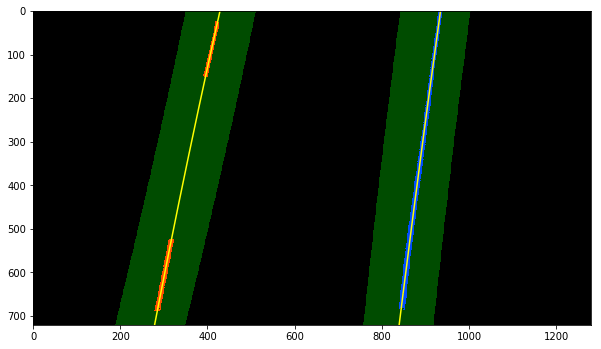

In [13]:
test_img1 = cv2.imread('./test_images/straight_lines1.jpg')
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
test_img1_binary, _ = alf.binary_img_pipeline(test_img1)   

test_img2 = cv2.imread('./test_images/straight_lines2.jpg')
tes_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
test_img2_binary, _ = alf.binary_img_pipeline(test_img2)   
margin = 80

left_fit1, right_fit1, left_lane_inds1, right_lane_inds1, windows_data1, histogram1 = alf.sliding_window_lane_fit_polynomial(test_img1_binary)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = alf.lane_fit_from_prev_frame(test_img2_binary, left_fit1, right_fit1)


ploty = np.linspace(0, test_img2_binary.shape[0]-1, test_img2_binary.shape[0] )
left_fitx = left_fit1[0]*ploty**2 + left_fit1[1]*ploty + left_fit1[2]
right_fitx = right_fit1[0]*ploty**2 + right_fit1[1]*ploty + right_fit1[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]


out_img = np.uint8(np.dstack((test_img2_binary, test_img2_binary, test_img2_binary))*255)
window_img = np.zeros_like(out_img)


nonzero = test_img2_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]


left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))


cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(10,18))
plt.imshow(result)
plt.imsave('./output_images/previous_frame_fit.png', result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### 6 Radius of curvature calculation
<a id='rad-curv-test'></a>

In [14]:
test_img_straight = cv2.imread('./test_images/straight_lines1.jpg')
test_img_straight = cv2.cvtColor(test_img_straight, cv2.COLOR_BGR2RGB)
testimg_binary, _ = alf.binary_img_pipeline(test_img_straight)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary)
radius, d_center, position = alf.calc_radius_curvature(testimg_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for straight lane:', radius, 'm')
print('Distance from lane center for straight lane:', d_center, 'm')

test_img_curved = cv2.imread('./test_images/test2.jpg')
test_img_curved = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
testimg_binary_curved, Minv = alf.binary_img_pipeline(test_img_curved)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary_curved)
radius, d_center, position = alf.calc_radius_curvature(testimg_binary_curved, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for curved lane:', radius, 'm')
print('Distance from lane center for curved lane:', d_center, 'm')

Radius of curvature for straight lane: 7715 m
Distance from lane center for straight lane: 0.455897271284 m
Radius of curvature for curved lane: 2444 m
Distance from lane center for curved lane: 0.253271465751 m


#### 7 Lane identification
<a id='lane-area-id-test'></a>

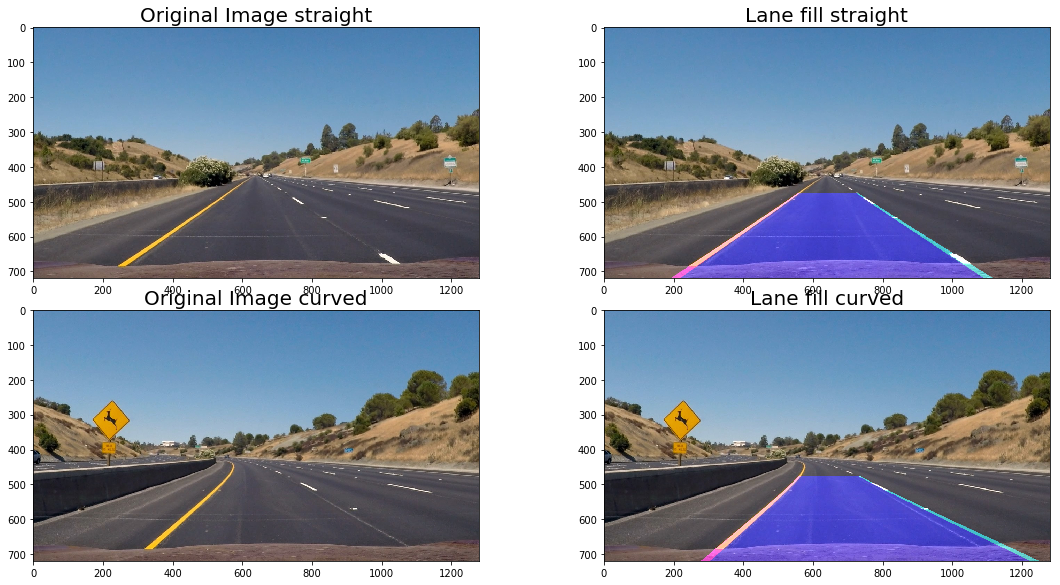

In [15]:
test_img_curved = cv2.imread('./test_images/test2.jpg')
test_img_curved = cv2.cvtColor(test_img_curved, cv2.COLOR_BGR2RGB)
testimg_binary_curved, Minv = alf.binary_img_pipeline(test_img_curved)
left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary_curved)
testimg_out_curved = alf.lane_area_identify(test_img_curved, testimg_binary_curved, left_fit, right_fit, Minv)

test_img_straight = cv2.imread('./test_images/straight_lines1.jpg')
test_img_straight = cv2.cvtColor(test_img_straight, cv2.COLOR_BGR2RGB)
testimg_binary_straight, Minv = alf.binary_img_pipeline(test_img_straight)
left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary_straight)
testimg_out_straight = alf.lane_area_identify(test_img_straight, testimg_binary_straight, left_fit, right_fit, Minv)

fig, axs = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(hspace = 0, wspace=0)
plt.tight_layout()
axs = axs.ravel()

plt.imsave('./output_images/lane_id_straight.png', testimg_out_straight)
plt.imsave('./output_images/lane_id_curved.png', testimg_out_curved)

    
axs[0].set_title('Original Image straight', fontsize=20)
axs[0].imshow(test_img_straight)
axs[1].set_title('Lane fill straight', fontsize=20)
axs[1].imshow(testimg_out_straight)
                    
axs[2].set_title('Original Image curved', fontsize=20)
axs[2].imshow(test_img_curved)
axs[3].set_title('Lane fill curved', fontsize=20)
axs[3].imshow(testimg_out_curved)

#### Curvature data for lanes

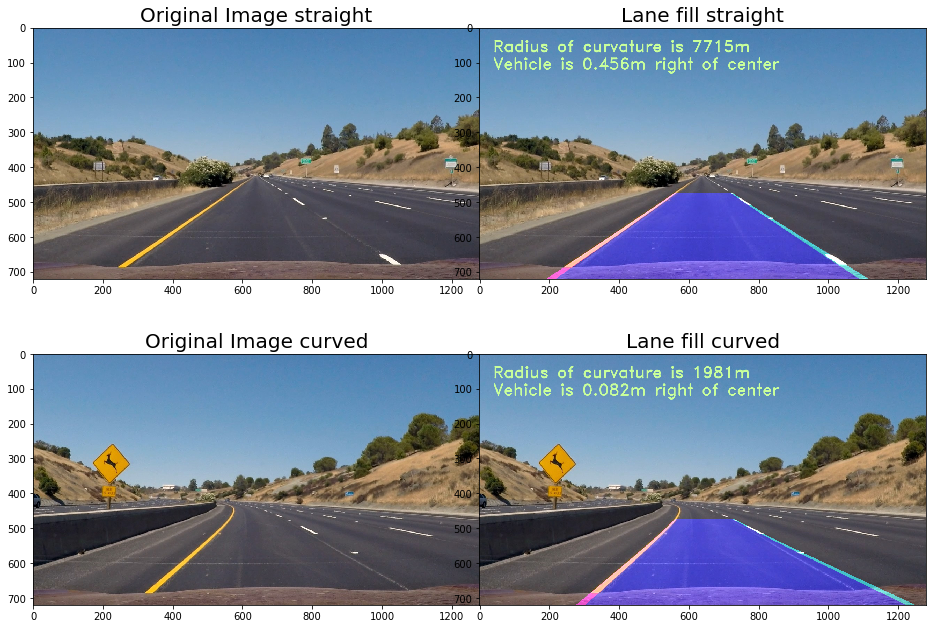

In [16]:
left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary_straight)
radius, d_center, position = alf.calc_radius_curvature(testimg_binary_straight, left_fit, right_fit, left_lane_inds, right_lane_inds)
testimg_data_straight = alf.project_to_road(testimg_out_straight, radius, d_center, position)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = alf.sliding_window_lane_fit_polynomial(testimg_binary_curved)
radius, d_center, position = alf.calc_radius_curvature(testimg_binary_curved, left_fit, right_fit, left_lane_inds, right_lane_inds)
testimg_data_curved = alf.project_to_road(testimg_out_curved, radius, d_center, position)
fig, axs = plt.subplots(2, 2, figsize=(16, 12), squeeze=True)
fig.subplots_adjust(hspace = 0, wspace=0)

axs = axs.ravel()

plt.imsave('./output_images/lane_id_straight_stats.png', testimg_data_straight, dpi=100)
plt.imsave('./output_images/lane_id_curved_stats.png', testimg_data_curved)

    
axs[0].set_title('Original Image straight', fontsize=20)
axs[0].imshow(test_img_straight)
axs[1].set_title('Lane fill straight', fontsize=20)
axs[1].imshow(testimg_data_straight)
                    
axs[2].set_title('Original Image curved', fontsize=20)
axs[2].imshow(test_img_curved)
axs[3].set_title('Lane fill curved', fontsize=20)
axs[3].imshow(testimg_data_curved)

#### 8. Pipeline video
<a id='video-proc'></a>

In [17]:
alf.set_line()
project_video_output = 'project_video_output.mp4'
project_video = VideoFileClip("project_video.mp4")
processed_video = project_video.fl_image(alf.process_image_frame)
%time processed_video.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [05:20<00:00,  3.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 21s


In [18]:
alf.set_line()
challenge_video_output = 'challenge_video_output.mp4'
challenge_video = VideoFileClip("challenge_video.mp4")
processed_video = challenge_video.fl_image(alf.process_image_frame)
%time processed_video.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [02:05<00:00,  3.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 6s
